In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.odr as odr
from glob import glob
import re
from toolz import curry
from tqdm import tqdm

np.seterr(all="ignore") # ignore invalid float operations
plt.rcParams["figure.dpi"] = 130 

#### Create output dirs

In [2]:
for var in ['xuv', 'xdv', 'xubar', 'xdbar', 'xgl']:
    os.makedirs(f"img/{var}",exist_ok=True)
os.makedirs("img/parameters",exist_ok=True)

#### Definitions

In [3]:
def model(B,X):
    return (1-X+1e-6)**B[2]*X**B[1]*B[0]*(1 + X*B[3] + X**2*B[4] + B[5]*np.log(X) + B[6]*np.log(X)**2)

def parse_filename_Q2(fname):
    return float(re.search("(?<=_)[\d\.*]+(?=.csv)",fname).group(0))

def ord_fit_object(fname,var,beta0=np.ones(7),iterations=5000):
    data = pd.read_csv(fname,sep=" ")
    return odr.ODR(
        odr.Data(data["x"].values, data[var].values),
        odr.Model(model),
        beta0=beta0,
        maxit=iterations,
        ifixx=np.zeros(len(data["x"]))
    )

fnames = glob("csv/*.csv")
fnames = sorted(fnames, key=parse_filename_Q2)
variables = pd.read_csv(fnames[0],sep=" ").set_index("x").columns

## Fit

In [21]:
var_residuals = {}
var_results = []
for var in variables:
    #last_fit = None
    parameters = {}
    max_residual= {}
    for i,fname in tqdm(enumerate(fnames),desc=var,total=(len(fnames))):
        data = pd.read_csv(fname,sep=" ")

        fit = odr.ODR(
            odr.Data(data["x"].values,data[var].values),
            odr.Model(model),
            beta0= np.ones(7) if var=="xdv" else np.ones(7)*0.6 if var=="xubar" else np.zeros(7) ,
            maxit=5000,
            ifixx=np.zeros(len(data["x"]))
        ).run()

        response = model(fit.beta,data["x"])

        fig,ax = plt.subplots(
            nrows=2,
            figsize=(7,7),
            dpi=150,
            sharex=True,
            gridspec_kw={"height_ratios":[4,2]}
        )

        plt.sca(ax[0])
        plt.title(f"$Q^2 = {parse_filename_Q2(fname):.3e}$")
        plt.plot(data["x"],response,c='k',linestyle=(0,(5,5)))
        plt.scatter(data["x"],data[var],s=3)
        plt.ylabel(var,fontsize=16)

        plt.sca(ax[1])
        plt.scatter(data["x"], response-data[var],s=3)

        plt.xscale("log")
        plt.tight_layout()
        plt.savefig(f"./img/{var}/q2_{parse_filename_Q2(fname)}.png")
        plt.close()

        parameters[parse_filename_Q2(fname)] = pd.Series(fit.beta,name="Beta",index=list("abcdefg"))
        max_residual[parse_filename_Q2(fname)] = max(abs(response-data[var]))

    var_results.append(
        pd.concat(parameters).rename(var)
    )
    var_residuals[var] = max_residual

xgl: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:37<00:00,  1.08s/it]


#### Organize results

In [22]:
fit_results = pd.concat(var_results,axis=1)
fit_results.index.names = ["Q^2","par"]
fit_results.sort_index(inplace=True)
fit_results.head(14)

xuv        xdv      xubar      xdbar         xgl
Q^2      par                                                       
2.560000 a    0.967721   1.485316   1.524409   4.204773  132.339317
         b    0.051236   0.003116   0.116444   0.178213    0.500376
         c    1.946229   6.242114  10.947327  15.280213   11.739785
         d    4.089238  -2.091748   0.528139  -3.659396   -2.584344
         e   -6.574465  18.822694  -0.389846   5.384535    4.837941
         f    0.171287   0.218152   0.274980   0.300742    0.459483
         g    0.028720   0.022063   0.042313   0.036063    0.066720
4.499704 a    0.988081   1.420873   2.092522   4.088064   76.794775
         b    0.050218  -0.002335   0.146939   0.174596    0.408834
         c    1.996651   6.291212   6.128844  15.441703   10.998199
         d    3.900896  -2.014626  -2.546242  -3.671236   -2.476835
         e   -6.347103  19.083863   1.990243   5.564008    4.715526
         f    0.174027   0.213741   0.307638   0.300248    0.459075
         g    0.029012   0.021769   0.045121   0.036349    0.069473

In [23]:
max_residuals = pd.DataFrame.from_dict(var_residuals)
max_residuals.index.name = "Q^2"
max_residuals.sort_index(inplace=True)
max_residuals

,xuv,xdv,xubar,xdbar,xgl
Q^2,,,,,
2.560000e+00,0.010395,0.006280,0.000067,0.000293,0.055956
4.499704e+00,0.009566,0.006096,0.000372,0.000221,0.040945
7.909116e+00,0.008833,0.005926,0.000277,0.000158,0.031741
1.390183e+01,0.008176,0.005787,0.000196,0.000105,0.025456
2.443520e+01,0.007642,0.005658,0.000156,0.000106,0.020990
4.294967e+01,0.007201,0.005533,0.000131,0.000125,0.017703
7.549251e+01,0.006801,0.005414,0.000110,0.000141,0.015232
1.326929e+02,0.006441,0.005298,0.000091,0.000156,0.013321
2.332340e+02,0.006111,0.005187,0.000076,0.000169,0.011784


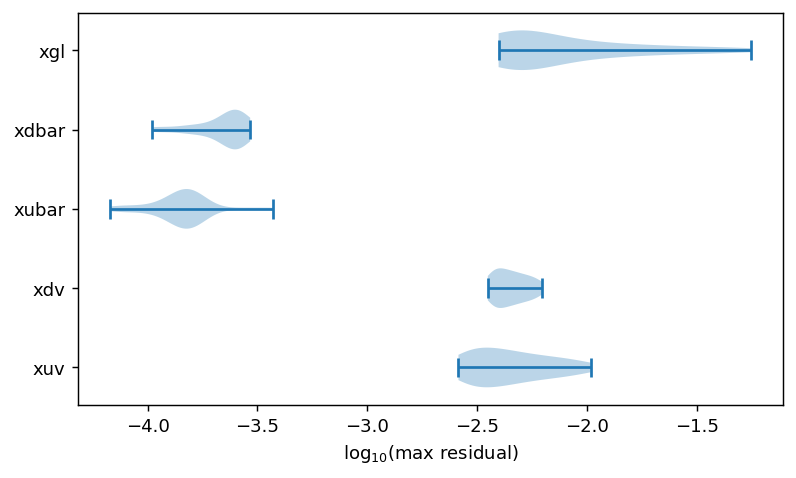

In [24]:
plt.figure(figsize=(7,4))
plt.violinplot(np.log10(max_residuals),vert=False)
plt.yticks(ticks=range(1,6),labels=max_residuals.columns)
plt.xlabel(r"$\log_{10}($max residual$)$")
plt.savefig("img/violin_residual.png",dpi=300)

In [46]:
for par in tqdm("abcdefg"):
    plot_df = fit_results.xs(par,level=1)
    ptp = plot_df.values.ptp()
    xmin = plot_df.values.min()
    xmax = plot_df.values.max()
    plot_df = plot_df.reset_index()
    label = r"$\log(Q^2) / \log(2.56^2)$"
    plot_df[label] = np.log(plot_df["Q^2"])/np.log(2.56**2)

    plt.figure(figsize=(7,4))
    for y in fit_results.columns:
        plot_df.plot.scatter(x=label,y=y,ax=plt.gca(),c='k',s=3)
    plot_df.plot(x=label,y=fit_results.columns,ylabel=f"{par} parameter",ax=plt.gca())
    if ptp > 30:
        plt.yscale("log" if xmin>0 else "symlog")
    plt.tight_layout()
    plt.savefig(f"img/parameters/{par}.png",dpi=300)
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.64it/s]
